In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.rcParams["figure.figsize"] = (10, 5)


def load_spectrum(file_df, file_db):
    """Laad Doppler free (DF) en Doppler broadened (DB) uit twee CSV bestanden."""
    df_df = pd.read_csv(file_df, skiprows=20, header=None)
    df_db = pd.read_csv(file_db, skiprows=20, header=None)

    # Doppler free
    x1 = pd.to_numeric(df_df[3], errors="coerce")
    y1 = pd.to_numeric(df_df[4], errors="coerce")
    mask1 = (~x1.isna()) & (~y1.isna())
    x1 = x1[mask1].reset_index(drop=True)
    y1 = y1[mask1].reset_index(drop=True)

    # Doppler broadened
    x2 = pd.to_numeric(df_db[3], errors="coerce")
    y2 = pd.to_numeric(df_db[4], errors="coerce")
    mask2 = (~x2.isna()) & (~y2.isna())
    x2 = x2[mask2].reset_index(drop=True)
    y2 = y2[mask2].reset_index(drop=True)

    return x1, y1, x2, y2


def align_spectra_on_minimum(x_df, y_df, x_db, y_db):
    """
    Maak x-grid gelijk door DF op DB te interpoleren.
    Eerst schuif DF zodat de minima samenvallen, daarna interpolate.
    Retourneert x_common, y_df_aligned, y_db_common.
    """
    x_df = np.asarray(x_df)
    y_df = np.asarray(y_df)
    x_db = np.asarray(x_db)
    y_db = np.asarray(y_db)

    # index van minima
    idx_df = np.argmin(y_df)
    idx_db = np.argmin(y_db)

    # hoeveel tijd moeten we DF verschuiven zodat minima gelijk liggen
    shift = x_db[idx_db] - x_df[idx_df]
    x_df_shifted = x_df + shift

    # gemeenschappelijk bereik
    xmin = max(x_df_shifted.min(), x_db.min())
    xmax = min(x_df_shifted.max(), x_db.max())
    mask = (x_db >= xmin) & (x_db <= xmax)

    x_common = x_db[mask]
    y_db_common = y_db[mask]

    # interpolate DF naar x_common
    y_df_interp = np.interp(x_common, x_df_shifted, y_df)

    return x_common, y_df_interp, y_db_common


def gaussian(f, A, f0, sigma, offset):
    return offset + A * np.exp(-((f - f0) ** 2) / (2 * sigma**2))


def lorentzian(f, A, f0, gamma, offset):
    return offset + A * gamma**2 / ((f - f0) ** 2 + gamma**2)


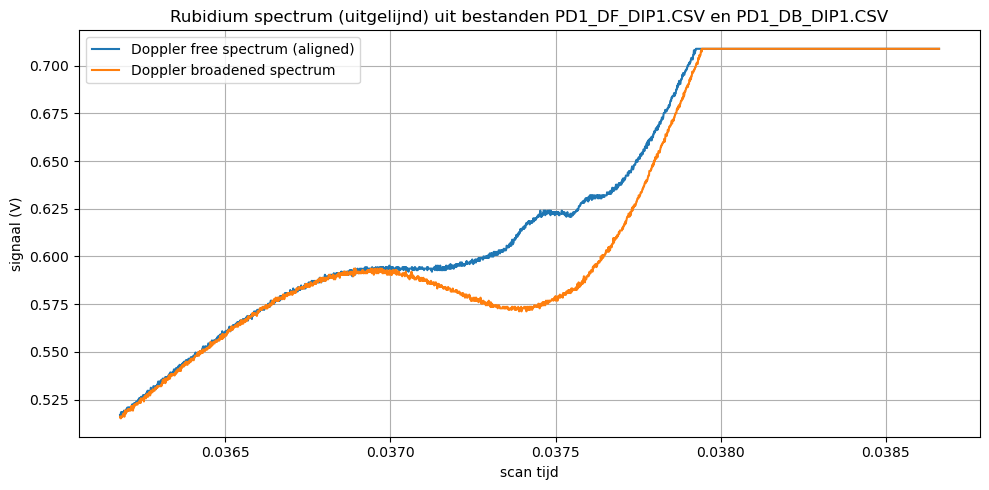

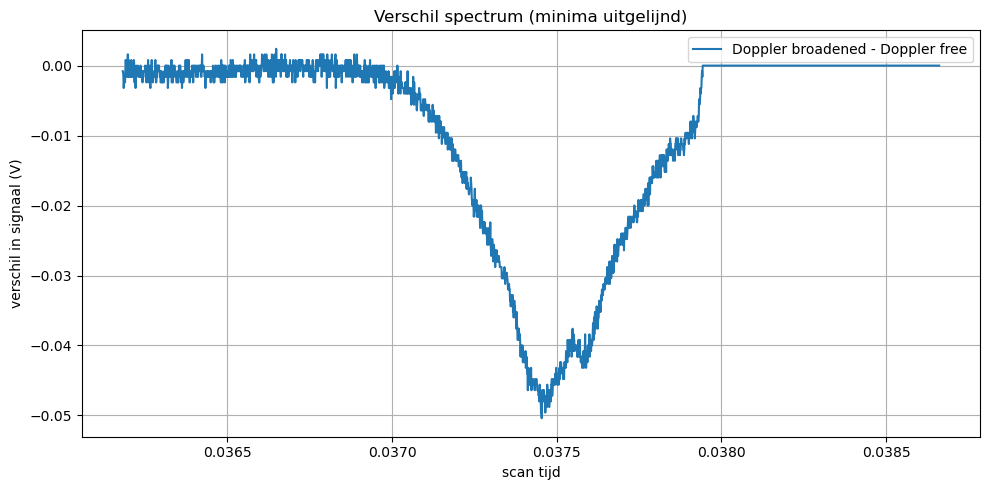

In [16]:
# KIES HIER WELKE CSV bestanden je wilt gebruiken

# PD1 DIP1
file_df = "PD1_DF_DIP1.CSV"  # Doppler free
file_db = "PD1_DB_DIP1.CSV"  # Doppler broadened

# andere opties:
# PD1 DIP2
# file_df = "PD1_DF_DIP2.CSV"
# file_db = "PD1_DB_DIP2.CSV"

# PD2 DIP1
# file_df = "PD2_DF_DIP1.CSV"
# file_db = "PD2_DB_DIP1.CSV"

# PD2 DIP2
# file_df = "PD2_DF_DIP2.CSV"
# file_db = "PD2_DB_DIP2.CSV"

# 1) laad ruwe data
x1_raw, y1_raw, x2_raw, y2_raw = load_spectrum(file_df, file_db)

# 2) align + interpolate zodat minima samenvallen
x_common, y1_aligned, y2_common = align_spectra_on_minimum(
    x1_raw, y1_raw, x2_raw, y2_raw
)

# zet terug in pandas Series (fijn voor later)
x1 = pd.Series(x_common)  # tijd-as (nu gelijk voor beide)
x2 = x1.copy()  # zelfde as
y1 = pd.Series(y1_aligned)  # Doppler free, uitgelijnd
y2 = pd.Series(y2_common)  # Doppler broadened

# 3) verschil: BROADENED - FREE
y_diff = y2 - y1

# Plot beide spectra
plt.figure()
plt.plot(x1, y1, label="Doppler free spectrum (aligned)")
plt.plot(x2, y2, label="Doppler broadened spectrum")
plt.xlabel("scan tijd")
plt.ylabel("signaal (V)")
plt.title(f"Rubidium spectrum (uitgelijnd) uit bestanden {file_df} en {file_db}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot DB - DF
plt.figure()
plt.plot(x1, y_diff, label="Doppler broadened - Doppler free")
plt.xlabel("scan tijd")
plt.ylabel("verschil in signaal (V)")
plt.title("Verschil spectrum (minima uitgelijnd)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Totaal gevonden kandidaten: 6
Beschikbare properties: dict_keys(['prominences', 'left_bases', 'right_bases'])
Indices van de 2 diepste dips (in sub-array): [453 588]
Indices in volledige array: [1272 1407]


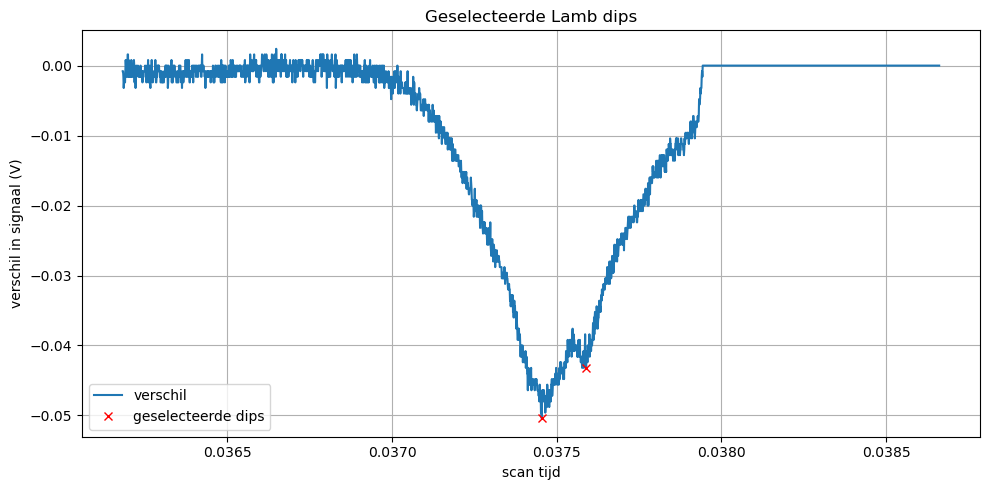

In [17]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# werk op het verschil-signaal y_diff en tijd-as x1

# venster kiezen rondom de interessante dips
mask = (x1 > 0.0370) & (x1 < 0.0380)  # pas grenzen aan als nodig
x_sub = x1[mask].to_numpy()
y_sub = y_diff[mask].to_numpy()

# zoek dips: pieken in -y_sub
peaks_all, props = find_peaks(
    -y_sub,
    distance=50,  # mag je aanpassen
    prominence=0.003,  # onder deze diepte negeert hij ruis
)

print("Totaal gevonden kandidaten:", len(peaks_all))
print("Beschikbare properties:", props.keys())

# sorteer op prominence (diepte) en kies de 2 diepste dips
order = np.argsort(props["prominences"])[::-1]
main_peaks = peaks_all[order[:2]]

print("Indices van de 2 diepste dips (in sub-array):", main_peaks)

# zet ze terug naar indices in de originele arrays
global_peaks = np.where(mask)[0][main_peaks]
print("Indices in volledige array:", global_peaks)

# plot ter controle
plt.figure()
plt.plot(x1, y_diff, label="verschil")
plt.plot(
    x1.iloc[global_peaks], y_diff.iloc[global_peaks], "rx", label="geselecteerde dips"
)
plt.xlabel("scan tijd")
plt.ylabel("verschil in signaal (V)")
plt.title("Geselecteerde Lamb dips")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


alpha = 6018518518518.687 Hz per tijdseenheid
beta  = -225925392592.59888 Hz bij tijd nul


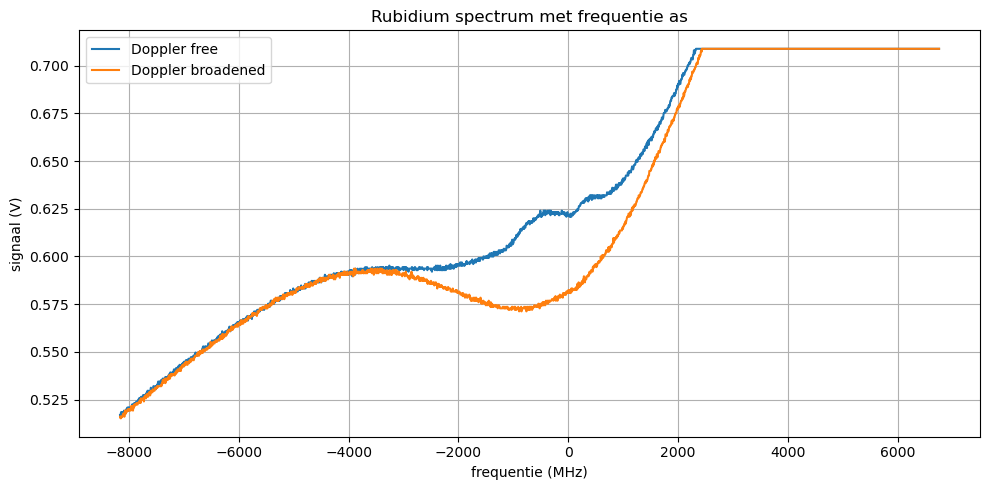

In [ ]:
# KIES HIER TWEE REFERENTIE DIPS EN HUN BEKENDE FREQUENTIES

# voorbeeld: vervang deze vier regels door jouw keuze
i1 = 1272  # eerste dip
i2 = 1407  # tweede dip

nu1_MHz = -507.8  # F'=1
nu2_MHz = 304.7  # F'=2

# vanaf hier niets meer aanpassen

t1 = x1.iloc[i1]
t2 = x1.iloc[i2]

nu1 = nu1_MHz * 1e6
nu2 = nu2_MHz * 1e6

alpha = (nu2 - nu1) / (t2 - t1)
beta = nu1 - alpha * t1

freq1 = alpha * x1 + beta
freq2 = alpha * x2 + beta

freq1_MHz = freq1 / 1e6
freq2_MHz = freq2 / 1e6

# print("alpha =", alpha, "Hz per tijdseenheid")
# print("beta  =", beta, "Hz bij tijd nul")

plt.figure()
plt.plot(freq1_MHz, y1, label="Doppler free")
plt.plot(freq2_MHz, y2, label="Doppler broadened")
plt.xlabel("frequentie (MHz)")
plt.ylabel("signaal (V)")
plt.title("Rubidium spectrum met frequentie as")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


dip 1:
  centrum frequentie f0 = -529.63 MHz
  FWHM (linewidth overgang) = 576.22 MHz

dip 2:
  centrum frequentie f0 = 350.05 MHz
  FWHM (linewidth overgang) = 279.34 MHz



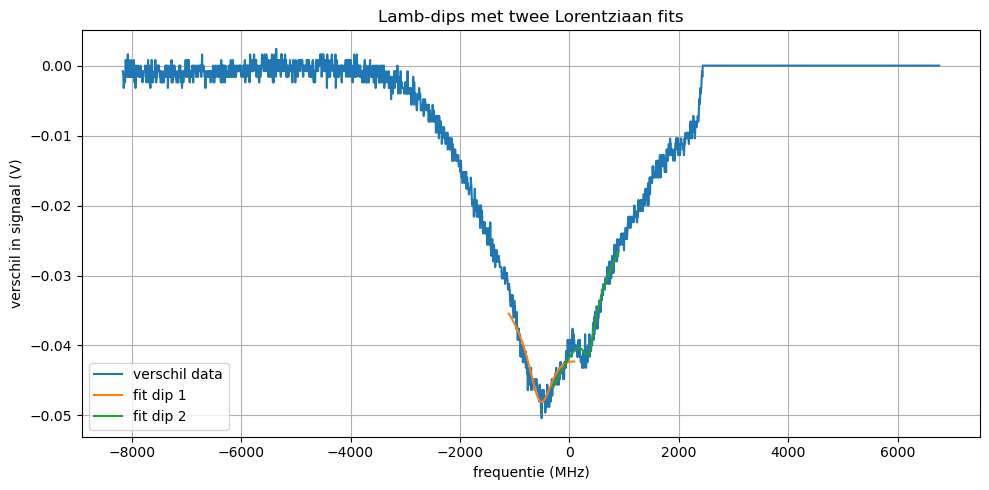

In [19]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def lorentz_simple(f, A, f0, gamma):
    """
    Eenvoudige Lorentziaan (zonder achtergrond):
    y(f) = A * gamma^2 / ((f - f0)^2 + gamma^2)
    A is negatief (dip).
    """
    return A * gamma**2 / ((f - f0) ** 2 + gamma**2)

# ---- kies hier de indices van de twee dips in de volledige array ----
# deze kwamen eerder uit "Indices in volledige array"
dip_indices = [1272, 1407]   # pas aan als je andere dips wilt
labels      = ["dip 1", "dip 2"]

results = []

plt.figure()
plt.plot(freq1_MHz, y_diff, label="verschil data")

for idx_center, lab in zip(dip_indices, labels):
    # 1) venster rond deze dip
    half_pts = 100                 # eventueel per dip aanpassen: bv. 80 of 120
    start = max(0, idx_center - half_pts)
    end   = min(len(y_diff), idx_center + half_pts)

    f_L = freq1_MHz.iloc[start:end].to_numpy()
    y_L = y_diff.iloc[start:end].to_numpy()

    # 2) lineaire achtergrond uit de randen van het venster
    edge_n = 20
    edge_idx = np.r_[0:edge_n, len(f_L) - edge_n : len(f_L)]
    m_bg, c_bg = np.polyfit(f_L[edge_idx], y_L[edge_idx], 1)
    baseline = m_bg * f_L + c_bg

    # 3) dip zonder achtergrond
    y_corr = y_L - baseline   # dip rond 0

    # 4) startwaarden voor Lorentziaan
    A0 = y_corr.min()          # negatieve amplitude
    f0_0 = f_L[np.argmin(y_corr)]
    window_width = f_L.max() - f_L.min()
    gamma0 = window_width / 10.0

    p0 = [A0, f0_0, gamma0]

    # 5) grenzen: A <= 0, gamma niet groter dan halve vensterbreedte
    bounds = (
        [-np.inf, f_L.min(), 0.0],             # A, f0, gamma min
        [0.0,     f_L.max(), window_width/2],  # A <= 0, gamma beperkt
    )

    pars_L, _ = curve_fit(
        lorentz_simple,
        f_L,
        y_corr,
        p0=p0,
        bounds=bounds,
        maxfev=20000
    )

    A_L, f0_L, gamma_L = pars_L
    FWHM_line = 2 * gamma_L
    results.append((lab, f0_L, FWHM_line))

    # 6) totale fit = baseline + Lorentziaan
    y_fit = baseline + lorentz_simple(f_L, *pars_L)

    # plot alleen in het lokale venster
    plt.plot(f_L, y_fit, label=f"fit {lab}")

# 7) resultaten printen
for lab, f0_L, FWHM_line in results:
    print(f"{lab}:")
    print(f"  centrum frequentie f0 = {f0_L:.2f} MHz")
    print(f"  FWHM (linewidth overgang) = {FWHM_line:.2f} MHz")
    print()

plt.xlabel("frequentie (MHz)")
plt.ylabel("verschil in signaal (V)")
plt.title("Lamb-dips met twee Lorentziaan fits")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




Aantal punten in fit: 1495
Gaussian fit Doppler verbrede lijn:
  centrum frequentie f0 = -407.10 MHz
  sigma = 1497.75 MHz
  FWHM (Doppler broadening) = 3526.94 MHz


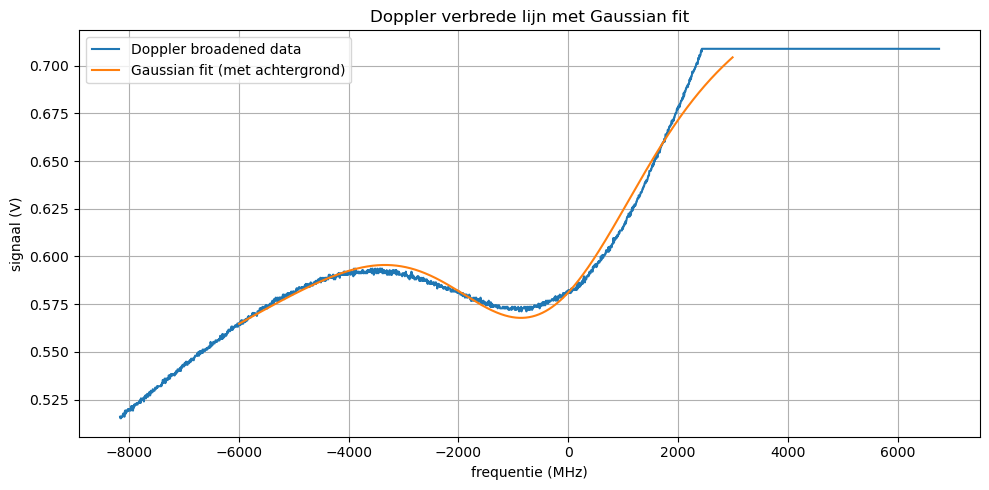

In [22]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian_simple(f, A, f0, sigma):
    """
    Eenvoudige Gauss:
    y(f) = A * exp(-(f - f0)^2 / (2 sigma^2))
    Voor een dip is A negatief.
    """
    return A * np.exp(-(f - f0)**2 / (2 * sigma**2))

# 0) KIES HIER DE FREQUENTIE RANGE VAN DE DOPPLER-DIP
# kijk in je spectrum en pas deze twee getallen aan
fit_min = -6000   # MHz, voorbeeld
fit_max =  3000   # MHz, voorbeeld

# 1) selecteer alleen het stuk rond de brede dip
mask = (freq2_MHz > fit_min) & (freq2_MHz < fit_max)
f_D = freq2_MHz[mask].to_numpy()
y_D = y2[mask].to_numpy()

print("Aantal punten in fit:", len(f_D))

# 2) lineaire achtergrond uit de randen van dit venster
edge_n = 40   # aantal punten aan elke kant voor achtergrondfit
edge_idx = np.r_[0:edge_n, len(f_D) - edge_n : len(f_D)]

m_bg, c_bg = np.polyfit(f_D[edge_idx], y_D[edge_idx], 1)
baseline = m_bg * f_D + c_bg

# 3) dip zonder achtergrond
y_corr = y_D - baseline    # nu een vrij symmetrische kom

# 4) startwaarden voor Gaussian
A0 = y_corr.min()          # negatieve amplitude
f0_0 = f_D[np.argmin(y_corr)]
window_width = f_D.max() - f_D.min()
sigma0 = window_width / 5.0

p0 = [A0, f0_0, sigma0]

# 5) grenzen: A <= 0, sigma niet te groot
bounds = (
    [-np.inf, f_D.min(), 0.0],             # A, f0, sigma min
    [0.0,     f_D.max(), window_width/2],  # A <= 0, sigma niet te groot
)

pars_G, _ = curve_fit(
    gaussian_simple,
    f_D,
    y_corr,
    p0=p0,
    bounds=bounds,
    maxfev=20000
)

A_G, f0_G, sigma_G = pars_G

# 6) FWHM uit sigma  dit is de Doppler broadening
FWHM_D = 2 * np.sqrt(2 * np.log(2)) * sigma_G

print("Gaussian fit Doppler verbrede lijn:")
print(f"  centrum frequentie f0 = {f0_G:.2f} MHz")
print(f"  sigma = {sigma_G:.2f} MHz")
print(f"  FWHM (Doppler broadening) = {FWHM_D:.2f} MHz")

# 7) totale fit (achtergrond + Gaussian) voor de plot
y_fit = baseline + gaussian_simple(f_D, *pars_G)

plt.figure()
plt.plot(freq2_MHz, y2, label="Doppler broadened data")
plt.plot(f_D, y_fit, label="Gaussian fit (met achtergrond)")
plt.xlabel("frequentie (MHz)")
plt.ylabel("signaal (V)")
plt.title("Doppler verbrede lijn met Gaussian fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

